In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
# import libraries
# import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
# import tensortools as tt
# import pywt
# import scaleogram as scg
import scipy
import scipy.signal
import pandas as pd

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

# import torch
# import torch.cuda

# import mtaper_specgram
# import test_function

In [3]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

In [4]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

# import mtaper_specgram

In [5]:
# sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
from bmi_idap.helpers.getVideoDirectoryProperties import getVideoDirectoryProperties

In [6]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

rapids-0.19


In [7]:
%matplotlib notebook

In [8]:
### find version of openCV
# # script currently works with v4.4.0
# (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
# print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# # print(cv2.getBuildInformation())

# ### find version of pytorch
# print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Linux. Using "/" for directory slashes


In [9]:
## == IMPORT DATA ==

## import S2p data

dir_s2p = r'/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210409/baseline/suite2p/plane0'

F = np.load(f'{dir_s2p}{slash_type}F.npy')
Fneu = np.load(f'{dir_s2p}{slash_type}Fneu.npy')
iscell = np.load(f'{dir_s2p}{slash_type}iscell.npy')
ops = np.load(f'{dir_s2p}{slash_type}ops.npy', allow_pickle=True)
spks = np.load(f'{dir_s2p}{slash_type}spks.npy')
stat = np.load(f'{dir_s2p}{slash_type}stat.npy', allow_pickle=True)

num_frames_S2p = F.shape[1]

In [10]:
## == IMPORT DATA ==

## Import ROI Classifier data

dir_ROIClassifier = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409'

IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)


<IPython.core.display.Javascript object>


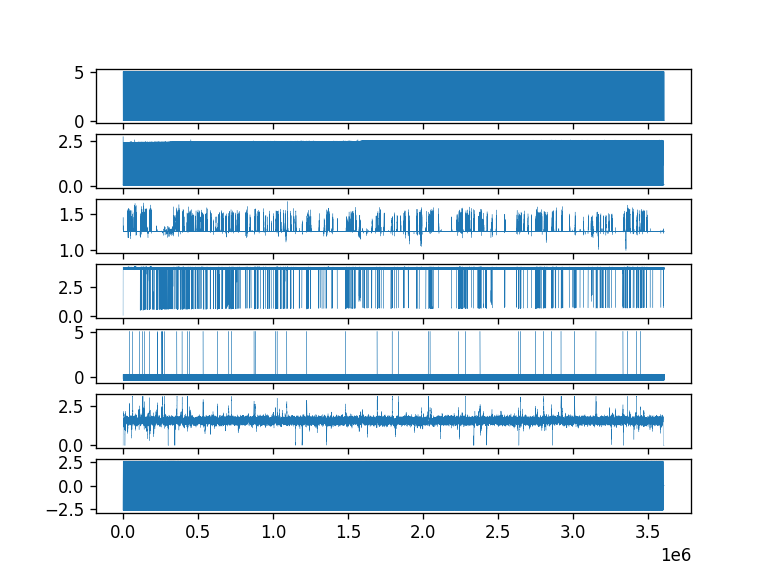

In [11]:
### import wavesurfer data

dir_ws = r'/media/rich/bigSSD RH/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210409'
fileName_ws = 'baseline_0002.h5'

data_as_dict = pywavesurfer.ws.loadDataFile(filename=f'{dir_ws}{slash_type}{fileName_ws}', format_string='double' )
ws_data = data_as_dict[f'{list(data_as_dict.keys())[1]}']['analogScans']

fig = plt.figure()
for ii in range(ws_data.shape[0]):
    subplot_size = int(str(ws_data.shape[0]) + str(1) + str(ii+1))
    ax1 = fig.add_subplot(subplot_size)
    plt.plot(ws_data[ii,:] , linewidth=0.2)

In [13]:
dir_cameraCSV = '/media/rich/bigSSD RH/res2p/Camera data/round 5 experiments/mouse 2_6/20210409/cam3/baseline'
fileName_cameraCSV = 'times_cam32021-04-09T19_45_53.csv'

from pathlib import Path
path_cameraCSV = Path(dir_cameraCSV) / fileName_cameraCSV

import pandas as pd
signal_GPIO = np.array(pd.read_csv(path_cameraCSV, sep=',',header=None))[:,0]

In [14]:
### import the face-rhythm temporal factors interp

# dir_faceRhythm = r'F:\RH_Local\Rich data\camera data\mouse 8.9b\20210109\cam2'
dir_faceRhythm = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/faceRhythm_data/run1_cam3/data'

fileName_faceRhythm = 'factors_spectral_temporal_interp.npy'
# fileName_faceRhythm = 'positions_new_sansOutliers.npy'
# factors_faceRhythm = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)
temporalFactors_faceRhythm = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

# fileName_faceRhythm = 'Sxx_allPixels_normFactor.npy'
# factors_faceRhythm_normFactor = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

In [15]:
# ### import the face-rhythm factors

# dir_faceRhythm = '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run4'
# fileName_faceRhythm = 'pca_temporalFactor.npy'

# pca_temporalFactor_faceRhythm = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

<IPython.core.display.Javascript object>


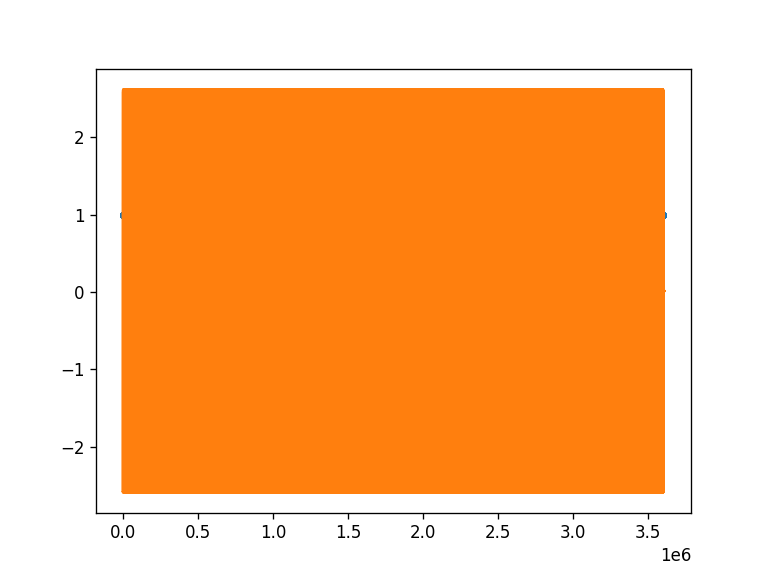

frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.359824074074076
total elapsed time: 0.15 seconds


In [16]:
## == ALIGN DATA ==

# Get ws frame times in ws time. Everything should be aligned to ws frame times (S2pInd)

# Outputs:
# - ws_YGalvoFlybacks_bool_wsTime
# - ws_frameTimes_wsTime   ***

tic = time.time()
ws_YGalvoFlybacks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[6,:]) < -1)) > 0.5

ws_frameTimes_wsTime = np.array(np.where(ws_YGalvoFlybacks_bool_wsTime))[0,:]
ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1]

plt.figure()
plt.plot(ws_frameTimes_wsTime,np.ones(len(ws_frameTimes_wsTime)),'.')
plt.plot(ws_data[6,:])
print(f'frames in scanimage movie = {num_frames_S2p}')
print(f'frames from ws galvo extraction movie = {ws_frameTimes_wsTime.shape[0]}')

ws_samples_per_S2p_frame_rough = (ws_frameTimes_wsTime[-1] - ws_frameTimes_wsTime[0]) / num_frames_S2p
print(f'number of wavesurfer samples per imaging frame:  {ws_samples_per_S2p_frame_rough}')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


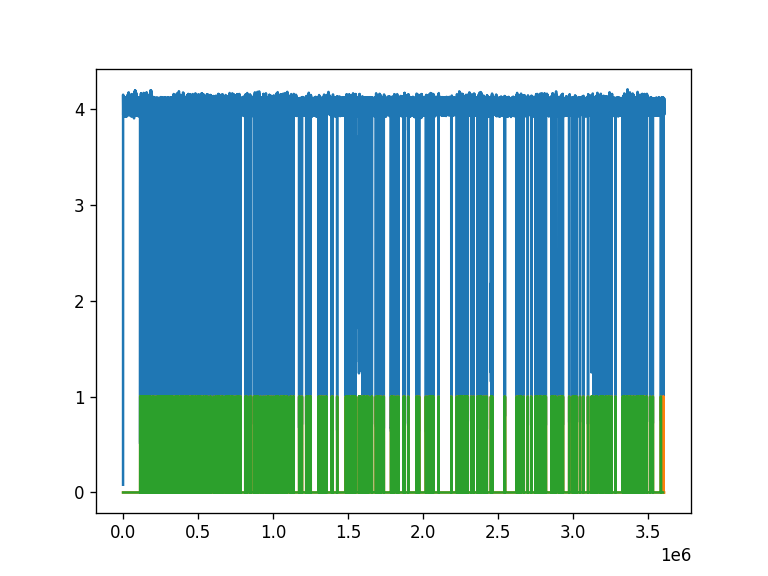

total elapsed time: 5.54 seconds


In [17]:
## Get lick times in S2p ind

# Outputs:
# - ws_licks_bool_wsTime
# - ws_licks_bool_S2pInd
# - ws_lickTimes_S2pInd   ***

tic = time.time()
ws_licks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[3,:]) < -0.2)) > 0.5

ws_licks_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_licks_bool_S2pInd[frame_num] = sum(ws_licks_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_lickTimes_S2pInd = np.array(np.where(ws_licks_bool_S2pInd))

plt.figure()
plt.plot(ws_data[3,:])
plt.plot(ws_licks_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_licks_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


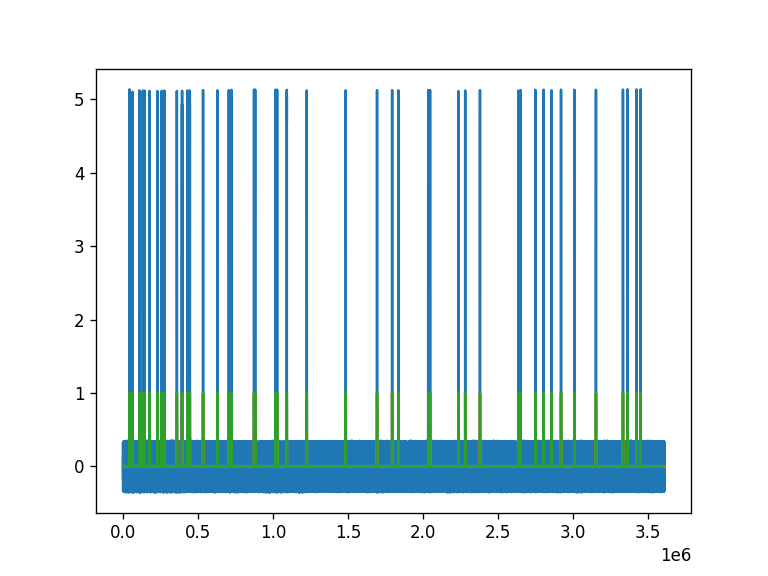

total elapsed time: 5.53 seconds


In [18]:
## Get reward delivery times in S2p ind

# Outputs:
# - ws_rewards_bool_wsTime
# - ws_rewards_bool_S2pInd
# - ws_rewardTimes_S2pInd   ***

tic = time.time()
ws_rewards_bool_wsTime = np.diff(np.int8(np.diff(ws_data[4,:]) > 1)) > 0.5


ws_rewards_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_rewards_bool_S2pInd[frame_num] = sum(ws_rewards_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_rewardTimes_S2pInd = np.array(np.where(ws_rewards_bool_S2pInd))

plt.figure()
plt.plot(ws_data[4,:])
plt.plot(ws_rewards_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_rewards_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [19]:
# np.double(ws_data[0,:].shape)/1000
# ws_data[0,int(987.5*1000):int(989*1000)]=0

<IPython.core.display.Javascript object>


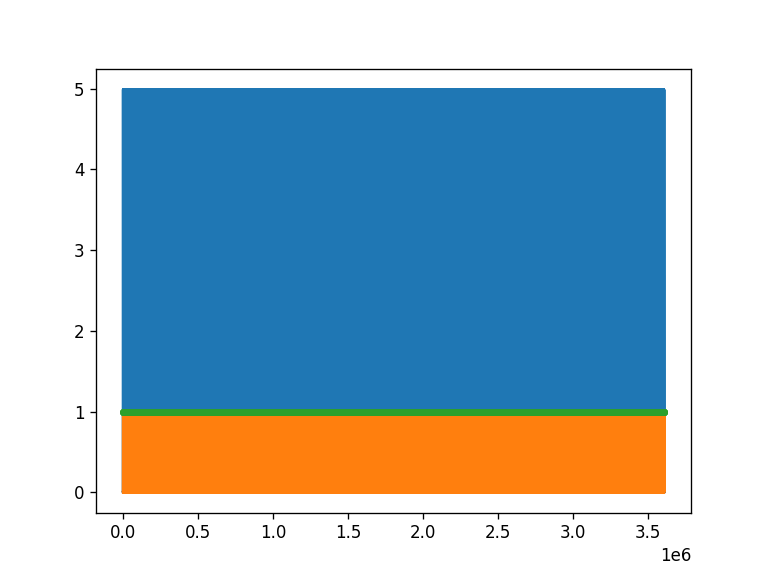

total elapsed time: 0.28 seconds


In [20]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - ws_camSignal_times

tic = time.time()
ws_camSignal_bool_wsTime = np.abs(np.hstack(([0] , np.diff(ws_data[0,:])))) > 1

ws_camSignal_wsTimes = np.where(ws_camSignal_bool_wsTime)[0]

plt.figure()
plt.plot(ws_data[0,:]);
plt.plot(ws_camSignal_bool_wsTime);
plt.plot(ws_camSignal_wsTimes, np.ones(len(ws_camSignal_wsTimes)).T ,'.');
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


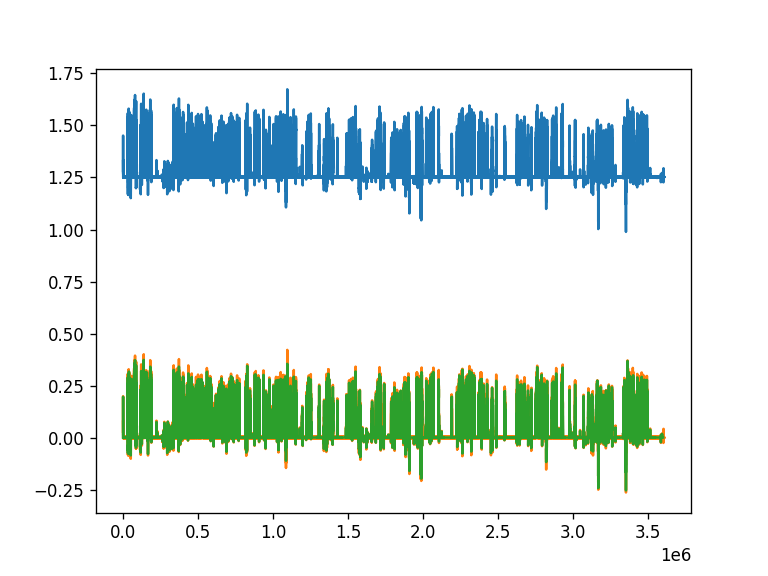

total elapsed time: 0.96 seconds


In [21]:
## Convert treadmill signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_treadmill_wsTime = ws_data[2,:] - np.percentile(ws_data[2,:], 20)

ws_treadmill_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_treadmill_S2pInd[frame_num] = sum(ws_treadmill_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_treadmill_S2pInd = ws_treadmill_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_treadmill_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_treadmill_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [22]:
signal_GPIO.shape

(436360,)

<IPython.core.display.Javascript object>


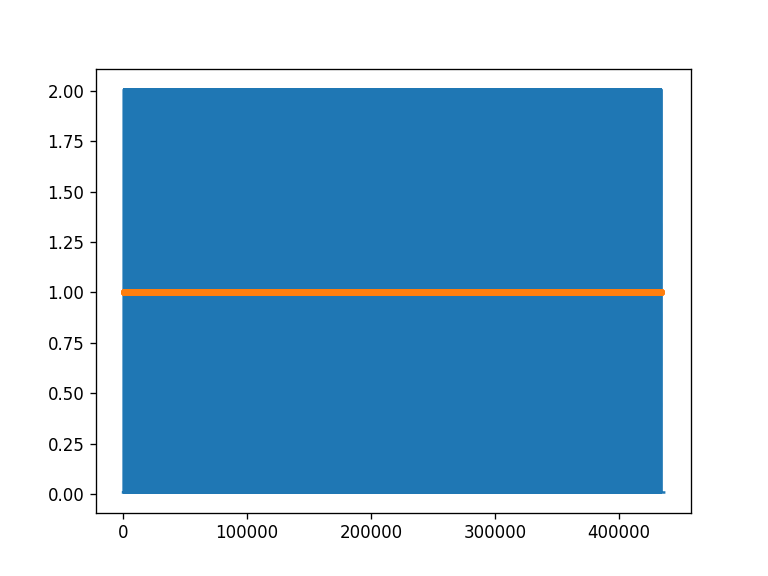

In [23]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - camera_camSignal_camTimes
# - camera_frames_wsTime ***

tic = time.time()
input_signal_GPIO = scipy.stats.zscore(np.double(signal_GPIO))

signal_GPIO_bool_camTime = np.abs(np.hstack(([0] , np.diff(input_signal_GPIO)))) > 1
# plt.figure()
# plt.plot(signal_GPIO_bool_camTime)

signal_GPIO_camTimes = np.where(signal_GPIO_bool_camTime)[0]

plt.figure()
plt.plot(input_signal_GPIO+1);
# plt.plot(camera_camSignal_bool_camTime);
# plt.plot(np.diff(pixels_topLeft[:,8]));
plt.plot(signal_GPIO_camTimes, np.ones(len(signal_GPIO_camTimes)).T ,'.');

In [24]:
print(ws_camSignal_wsTimes.shape)
print(signal_GPIO_camTimes.shape)

(7220,)
(7220,)


<IPython.core.display.Javascript object>


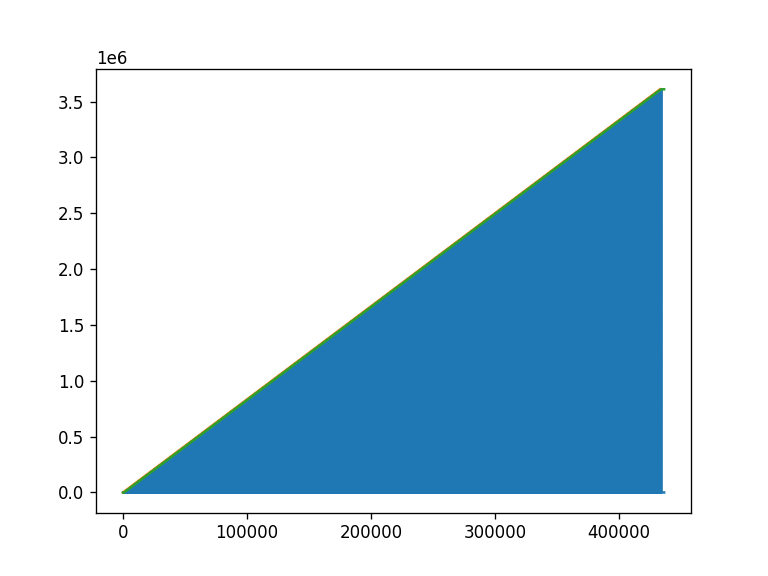

<IPython.core.display.Javascript object>


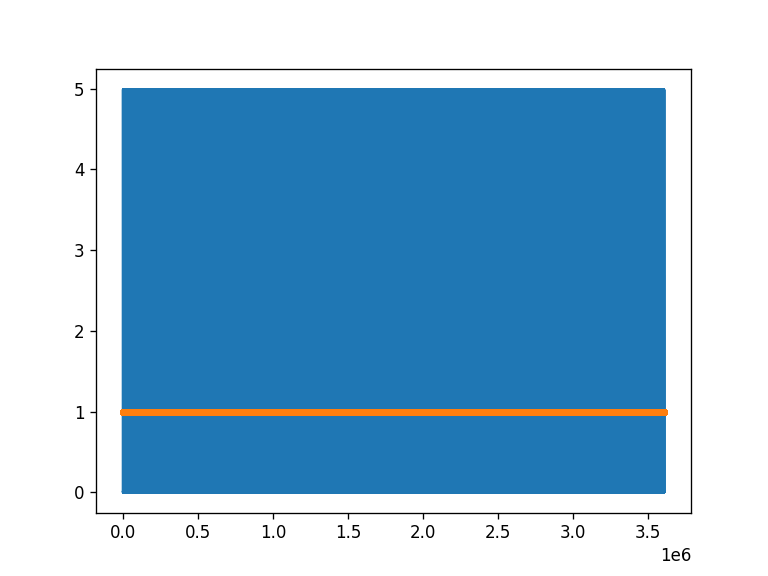

total elapsed time: 0.36 seconds


In [25]:
signal_GPIO_wsTimes = np.double(signal_GPIO_bool_camTime)
signal_GPIO_wsTimes[signal_GPIO_camTimes] = ws_camSignal_wsTimes
# signal_GPIO_wsTimes[signal_GPIO_camTimes] = crop_ws_camSignal_wsTimes
# plt.figure()
# plt.plot(signal_GPIO_wsTimes)

tmp = copy.deepcopy(signal_GPIO_wsTimes)
tmp[tmp==0] = np.nan
tmp = pd.DataFrame(tmp)
camera_frames_wsTimes = np.array(tmp.interpolate())
# plt.figure()
# plt.plot(camera_frames_wsTimes) 

tmp = copy.deepcopy(camera_frames_wsTimes)
tmp[np.isnan(tmp)] = 0
camera_frames_wsTimes_withLeadingZeros = np.int32(np.round(tmp))[:,0]
first_camFrame_camIdx = np.argmax(np.where(camera_frames_wsTimes_withLeadingZeros==0))+1
last_camFrame_camIdx = np.min(np.array(np.where(camera_frames_wsTimes_withLeadingZeros == np.max(camera_frames_wsTimes_withLeadingZeros))[0]))
camera_frames_wsTimes = camera_frames_wsTimes_withLeadingZeros[first_camFrame_camIdx:last_camFrame_camIdx]

plt.figure()
plt.plot(signal_GPIO_wsTimes)
plt.plot(camera_frames_wsTimes)
plt.plot(camera_frames_wsTimes_withLeadingZeros)

plt.figure()
plt.plot(ws_data[0,:])
plt.plot(camera_frames_wsTimes_withLeadingZeros , np.ones_like(camera_frames_wsTimes_withLeadingZeros) , '.')
# plt.plot(camera_frames_wsTimes , np.ones_like(camera_frames_wsTimes) , '.')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


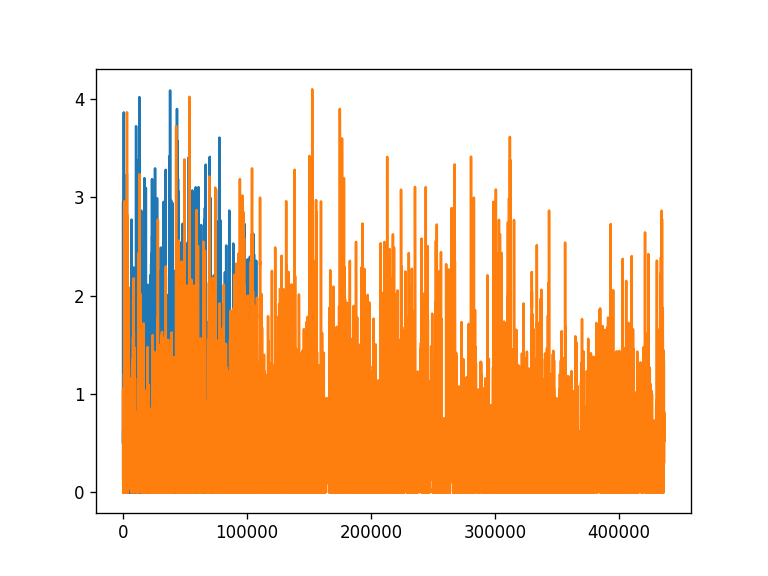

total elapsed time: 0.25 seconds


In [26]:
### resample factors_faceRhythm into ws and s2p times
# this script assumes that the GPIO sync trace has identical indexing as the video that was used for the factor decomposition (hopefully it's the same video)

tic = time.time()
# temporalFactors_faceRhythm = factors_faceRhythm[2]
# temporalFactors_faceRhythm = factors_faceRhythm_normFactor
upsample_factor = signal_GPIO.shape[0] / temporalFactors_faceRhythm.shape[0]

temporalFactors_camFrameTimes = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , len(temporalFactors_faceRhythm) )))
temporalFactors_Idx_withinWS = [(temporalFactors_camFrameTimes >= first_camFrame_camIdx) * 
                                (temporalFactors_camFrameTimes <= last_camFrame_camIdx)]
temporalFactors_withinWS = temporalFactors_faceRhythm[tuple(temporalFactors_Idx_withinWS)]
temporalFactors_camFrameIdx_withinWS = temporalFactors_camFrameTimes[tuple(temporalFactors_Idx_withinWS)]
temporalFactors_wsIdx_withinWS = camera_frames_wsTimes_withLeadingZeros[temporalFactors_camFrameIdx_withinWS]

function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic' , axis=0)
first_s2pIdx_usableForTemporalFactors = np.min(np.where(ws_frameTimes_wsTime > np.min(temporalFactors_wsIdx_withinWS)))

temporalFactors_s2pInd = function_interp(ws_frameTimes_wsTime[first_s2pIdx_usableForTemporalFactors:])
temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors , temporalFactors_s2pInd.shape[1])) , temporalFactors_s2pInd) , axis=0)
temporalFactors_s2pInd[temporalFactors_s2pInd < 0] = 0


plt.figure()
plt.plot(temporalFactors_s2pInd[:,0])
plt.plot(temporalFactors_faceRhythm[:,0])
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


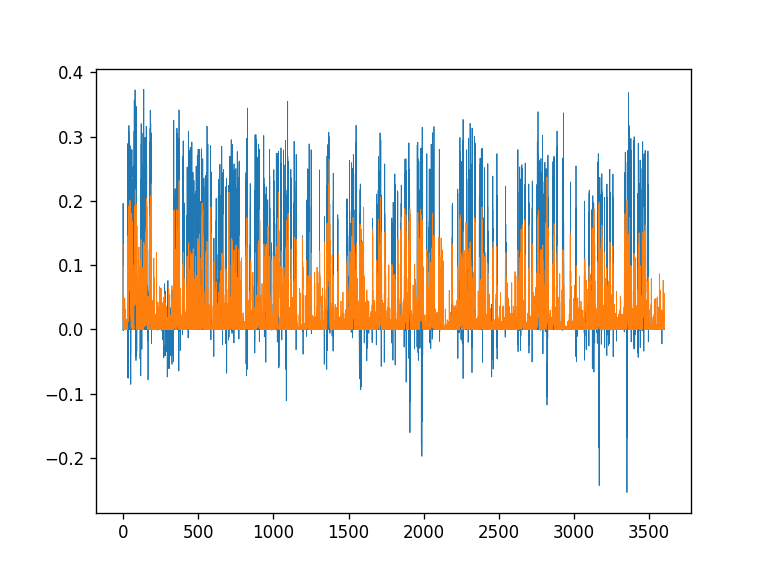

In [27]:
plt.figure()
plt.plot(np.arange(len(ws_treadmill_S2pInd))/30 , ws_treadmill_S2pInd , linewidth=-.5)
plt.plot(np.arange(len(ws_treadmill_S2pInd))/30 , (temporalFactors_s2pInd[:,7]**2)/20 , linewidth=-.5)


In [28]:
# ### resample pca_temporalFactor_faceRhythm into ws and s2p times
# # this script assumes that the GPIO sync trace has identical indexing as the video that was used for the factor decomposition (hopefully it's the same video)

# tic = time.time()
# # temporalFactors_faceRhythm = pca_temporalFactor_faceRhythm[:,0]
# temporalFactors_faceRhythm = abs(temp_Sxx)
# upsample_factor = signal_GPIO.shape[0] / temporalFactors_faceRhythm.shape[0]

# temporalFactors_camFrameTimes = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , len(temporalFactors_faceRhythm) )))
# temporalFactors_Idx_withinWS = [(temporalFactors_camFrameTimes >= first_camFrame_camIdx) * 
#                                 (temporalFactors_camFrameTimes <= last_camFrame_camIdx)]
# temporalFactors_withinWS = temporalFactors_faceRhythm[tuple(temporalFactors_Idx_withinWS)]
# temporalFactors_camFrameIdx_withinWS = temporalFactors_camFrameTimes[tuple(temporalFactors_Idx_withinWS)]
# temporalFactors_wsIdx_withinWS = camera_frames_wsTimes_withLeadingZeros[temporalFactors_camFrameIdx_withinWS]

# # function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic' , axis=0)
# function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic')
# first_s2pIdx_usableForTemporalFactors = np.min(np.where(ws_frameTimes_wsTime > np.min(temporalFactors_wsIdx_withinWS)))

# temporalFactors_s2pInd = function_interp(ws_frameTimes_wsTime[first_s2pIdx_usableForTemporalFactors:])
# # temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors , temporalFactors_s2pInd.shape[1])) , temporalFactors_s2pInd) , axis=0)
# temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors)) , temporalFactors_s2pInd))
# # temporalFactors_s2pInd[temporalFactors_s2pInd < 0] = 0


# plt.figure()
# # plt.plot(temporalFactors_s2pInd[:,0])
# # plt.plot(temporalFactors_faceRhythm[:,0])
# plt.plot(temporalFactors_faceRhythm)
# plt.plot(temporalFactors_s2pInd)
# print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [39]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 3.31 seconds


In [49]:
## Make rolling baseline subtraction
from bmi_idap.helpers import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(60 * 30 * 10)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

100%|██████████| 108000/108000 [01:14<00:00, 1445.32it/s]


In [50]:
## == REGRESSION ANALYSIS

<IPython.core.display.Javascript object>


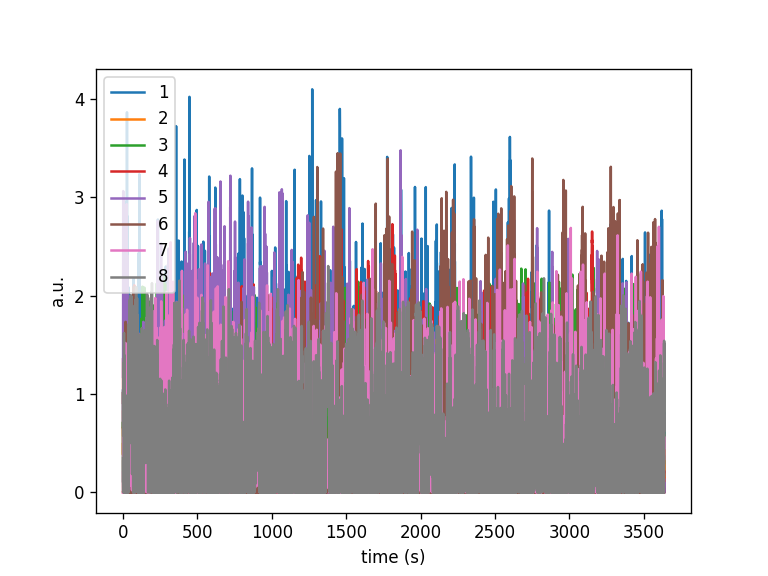

Text(0, 0.5, 'a.u.')

In [51]:
%matplotlib notebook

factors_toUse = temporalFactors_faceRhythm
modelRank = factors_toUse.shape[1]
## just for plotting in case 
if 'Fs' not in globals():
    Fs = 120

plt.figure()
# plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
# factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
factors_temporal = factors_toUse[:,:]
# factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,])
# plt.plot(factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

<IPython.core.display.Javascript object>


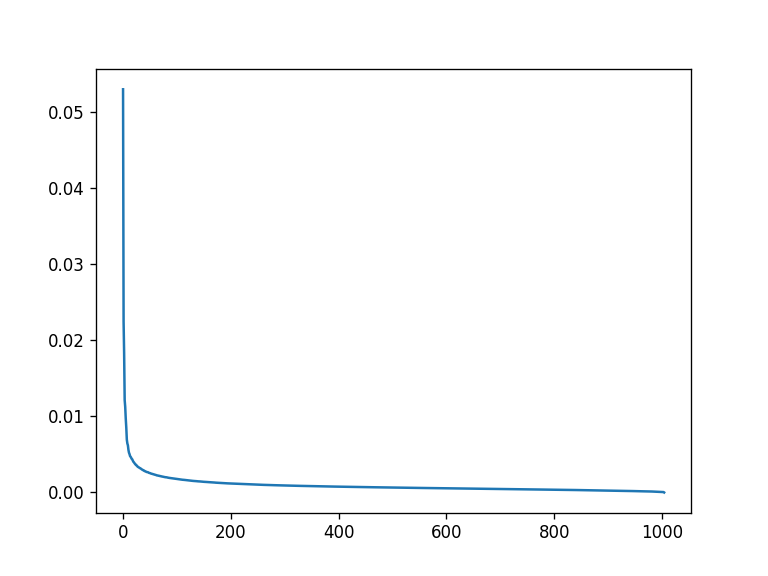

In [52]:
input_dimRed = F_zscore_roll[:,IsCell_ROIClassifier==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [53]:
output_PCA[:,1:].shape

(108000, 1004)

<IPython.core.display.Javascript object>


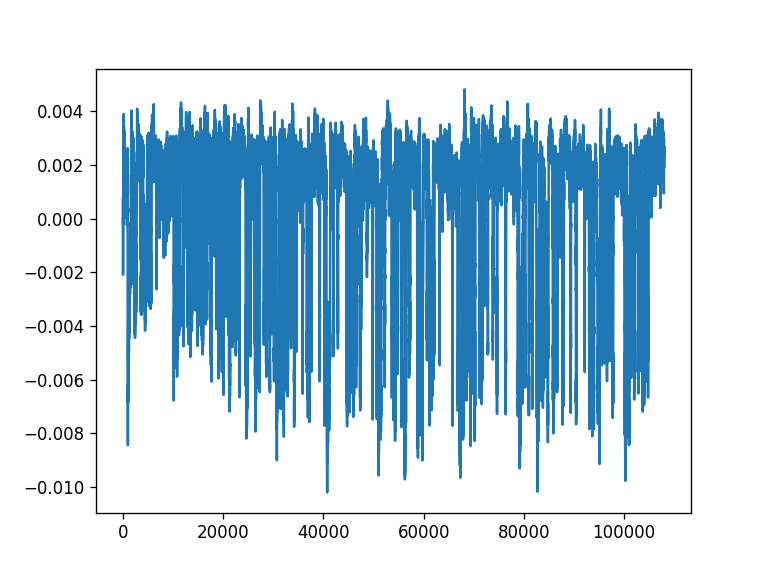

In [54]:
plt.figure()
plt.plot(output_PCA[:,0])

In [38]:
%matplotlib inline
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
#                           np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
#                           np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [300]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
X_input = scipy.stats.zscore(X_input , axis=0)

y_input = temporalFactors_s2pInd[:,:]

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = copy.deepcopy(y_input)

Number of labels: 30


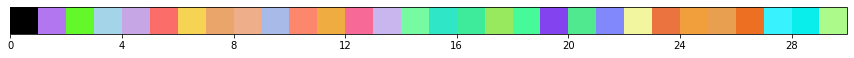

In [40]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)


np.random.seed(1338)
cmap_data = plt.cm.Accent
# cmap_data = plt.cm.coolwarm
# cmap_cv = plt.cm.coolwarm

# Generate the class/group data
Fs_2p = 30 # sample rate of 2p imaging data

n_points = X_input.shape[0]
group_len = 60*2 * Fs_2p # seconds * Fs
n_groups = int(n_points / group_len)
# X = np.random.randn(100, 10)
%matplotlib inline
cmap_data = rand_cmap(n_groups, type='bright', first_color_black=True, last_color_black=False, verbose=True)
cmap_cv = plt.cm.binary

<IPython.core.display.Javascript object>


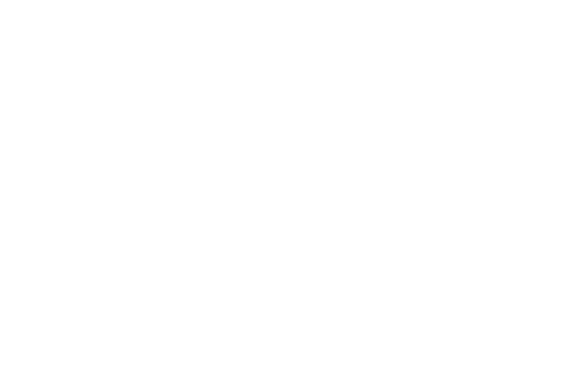

In [41]:
# Evenly spaced groups repeated once
groups = np.hstack([[ii]*group_len for ii in range(n_groups)])


def visualize_groups(classes, groups):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50,
               cmap=cmap_data,
              )

    ax.set(
#         ylim=[-1, 5],
        yticks=[.5],
        yticklabels=['Data\ngroup'],
        xlabel="Sample index")

%matplotlib notebook
%matplotlib notebook
visualize_groups(y_input, groups)

In [383]:
def make_cv_indices(cv, X, y, group, lw=20, plot_pref=True):
    """Create a sample plot for indices of a cross-validation object."""

    cv_idx = list(cv.split(X=X , y=y , groups=group))
    
    n_splits = cv.n_splits
    # Generate the training/testing visualizations for each CV split
    if plot_pref:
        fig, ax = plt.subplots()

    #     for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
            # Fill in indices with the training/test groups
            indices = np.array([np.nan] * len(X))
            indices[tt] = 1
            indices[tr] = 0

            # Visualize the results
            ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                       c=indices, marker='_', lw=lw, cmap=cmap_cv,
                       vmin=-.2, vmax=1.2)

        # Plot the data classes and groups at the end
    #     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
    #                c=y, marker='_', lw=lw, cmap=cmap_data)

        ax.scatter(range(len(X)), [ii + 1.5] * len(X),
                   c=group, marker='_', lw=lw, cmap=cmap_data)

        # Formatting
        yticklabels = list(range(n_splits)) + ['group']
        ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
               xlabel='Sample index', ylabel="CV iteration",
               ylim=[n_splits+1.2, -.2], xlim=[0, 108000])
        ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return cv_idx

<IPython.core.display.Javascript object>


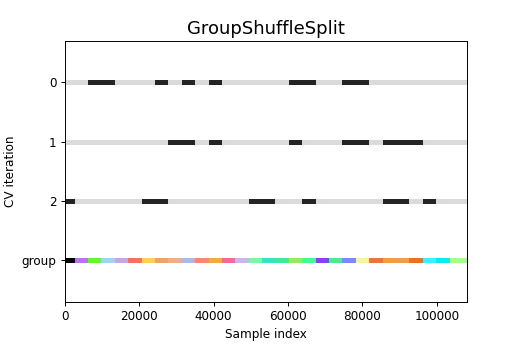

In [390]:
%matplotlib notebook
n_splits = 3
test_size = 0.3
cv = GroupShuffleSplit(n_splits, test_size=test_size)
sample_idx = np.arange(X_input.shape[0])
cv_idx = make_cv_indices(cv, sample_idx, sample_idx, groups, lw=20, plot_pref=True)

In [395]:
n_nonzero_rolls = 0

min_roll = 60*10*Fs_2p
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_rolls)))
n_rolls = n_nonzero_rolls + 1

In [362]:
import cudf
import cuml
import cupy

In [363]:
X = cupy.asarray(X)
y = cupy.asarray(y)

In [396]:
# alphas = np.array([
# #     0.0001 , 
#     0.002, 0.004, 0.008,
#     0.012, 0.02 ,
#     0.04 ,
# #     0.08 , 0.15 , 0.3 ,
# #     0.6
#         ])

alphas = np.array([
    0.008
])
# l1_ratios = np.array([1 , 0.99 , 0.95 , 0.9 , 0.7 , 0.5 , 0.2 ,
# #                       0.1 , 0.01
#                      ])
l1_ratios = np.array([0])

n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)

len_train = len(cv_idx[0][0])
len_test = len(cv_idx[0][1])

# y = np.zeros((X.shape[0] , num_factors , n_rolls))
theta_FF = np.ones((X_input.shape[1]+1 , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
R_train = np.zeros((num_factors, n_splits , n_rolls , n_alphas , n_l1Ratios))
R_test = np.zeros((num_factors,n_splits , n_rolls , n_alphas , n_l1Ratios))
y_reconstructed_FF = np.zeros((X_input.shape[0] , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_train_reconstructed_FF = np.zeros((len_train , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_test_reconstructed_FF = np.zeros((len_test , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))

for iter_factor in range(num_factors):
# for iter_factor in np.array([5]):
    for iter_roll in range(n_rolls):
#         y[:, iter_factor, iter_roll] = np.roll(y_input[:,iter_factor] , rolls[iter_roll])
        y_iter = np.roll(y[:,iter_factor] , rolls[iter_roll])

    #     X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    #         X, y[:,iter_factor], test_size=0.3, random_state=0)

        for iter_cv, (idx_train , idx_test) in enumerate(cv_idx):
            X_train = X[idx_train,:]
            y_train = y_iter[idx_train]
            X_test = X[idx_test,:]
            y_test = y_iter[idx_test]
            
            for iter_alpha , alpha in enumerate(alphas):
                for iter_l1Ratio , l1_ratio in enumerate(l1_ratios):

                    ### SKLEARN regression
#                     clf = sklearn.linear_model.Lasso(alpha=alpha,
#                                                      fit_intercept=False,
#                                                      normalize=False,
#                                                      precompute=False,
#                                                      copy_X=True,
#                                                      max_iter=1000,
#                                                      tol=0.0001,
#                                                      warm_start=True,
#                                                      positive=False,
#                                                      random_state=None,
#                                                      selection='cyclic'
#                                                     )
                    
#                     clf = sklearn.linear_model.ElasticNet(alpha=alpha,
#                                                           l1_ratio=l1_ratio,
#                                                           fit_intercept=False,
#                                                           normalize=False,
#                                                           precompute=False,
#                                                           max_iter=1000,
#                                                           copy_X=True,
#                                                           tol=0.0001,
#                                                           warm_start=True,
#                                                           positive=False,
#                                                           random_state=None,
#                                                           selection='cyclic'
#                                                          )
                    
#                     clf = sklearn.linear_model.SGDRegressor(loss='squared_loss',
#                                                             penalty='elasticnet',
#                                                             alpha=0.0001,
#                                                             l1_ratio=0.15,
#                                                             fit_intercept=True,
#                                                             max_iter=1000, 
#                                                             tol=0.001,
#                                                             shuffle=True,
#                                                             verbose=0,
# #                                                             epsilon=0.1,
# #                                                             random_state=None, 
#                                                             learning_rate='invscaling', 
#                                                             eta0=0.01, 
#                                                             power_t=0.25, 
# #                                                             early_stopping=False,
# #                                                             validation_fraction=0.1, 
# #                                                             n_iter_no_change=5,
#                                                             warm_start=True,
#                                                             average=False
#                                                            )


                    clf = cuml.linear_model.Lasso(alpha=alpha,
                                                       fit_intercept=False,
                                                       normalize=False,
                                                       max_iter=1000,
                                                       tol=0.0001,
                                                       selection='cyclic',
                                                       handle=None,
                                                       output_type='numpy',
                                                       verbose=False
                                                      )
                    
                    clf.fit(X_train , y_train )
#                     theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = clf.coef_
                    theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.coef_)


        #             theta_FF[:, iter_factor, iter_cv, iter_roll] = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

                    y_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]       = cupy.asnumpy(clf.predict(X))
                    y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.predict(X_train))
                    y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]  = cupy.asnumpy(clf.predict(X_test))
                

                    R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = (np.corrcoef(y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_train))[1,0]
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , train  R: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , train R^2: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)}')
                    print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , train  R: {cupy.around(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , train R^2: {cupy.around(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)}')

                    R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = (np.corrcoef(y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_test))[1,0]
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , test   R: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , test  R^2: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)} \n')
                    print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , test   R: {cupy.around(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , test  R^2: {cupy.around(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)} \n')

            gc.collect()

factor #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.511 , train R^2: 0.261
factor #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.29 , test  R^2: 0.084 

factor #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.514 , train R^2: 0.264
factor #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.284 , test  R^2: 0.081 

factor #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.514 , train R^2: 0.264
factor #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.243 , test  R^2: 0.059 

factor #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.804 , train R^2: 0.646
factor #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.775 , test  R^2: 0.601 

factor #: 1 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , tr

In [295]:
theta_FF[:,0,0,0,0,0].shape

(1006,)

In [290]:
y_train.shape

(75600, 8, 2)

In [397]:
# save regression outputs

cv_params = {
                    "rolls": rolls,
                    "group_len": group_len,
                    "groups": groups,
                    "n_groups": n_groups,
                    "n_splits": n_splits,
                    "test_size": test_size,
                    "min_roll": min_roll,
                    "cv_idx": cv_idx
}

regression_run = {
                    "alphas": alphas,
                    "l1_ratios": l1_ratios,
                    "IsCell_ROIClassifier": IsCell_ROIClassifier,
                    "X_input": X_input,
                    "y_input": y_input,
                    "theta_FF":theta_FF,
                    "y_reconstructed_FF": y_reconstructed_FF,
                    "y_train_reconstructed_FF": y_train_reconstructed_FF,
                    "y_test_reconstructed_FF": y_test_reconstructed_FF,
                    "R_train": R_train,
                    "R_test": R_test,
                    "cv_params": cv_params,
                    "linear_regression_model": clf
}


In [398]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409')
fileName_save = 'regression_run_'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , regression_run)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/regression_run_20210430.npy


In [503]:
R_test.shape

(8, 25, 4, 9, 1)

<IPython.core.display.Javascript object>


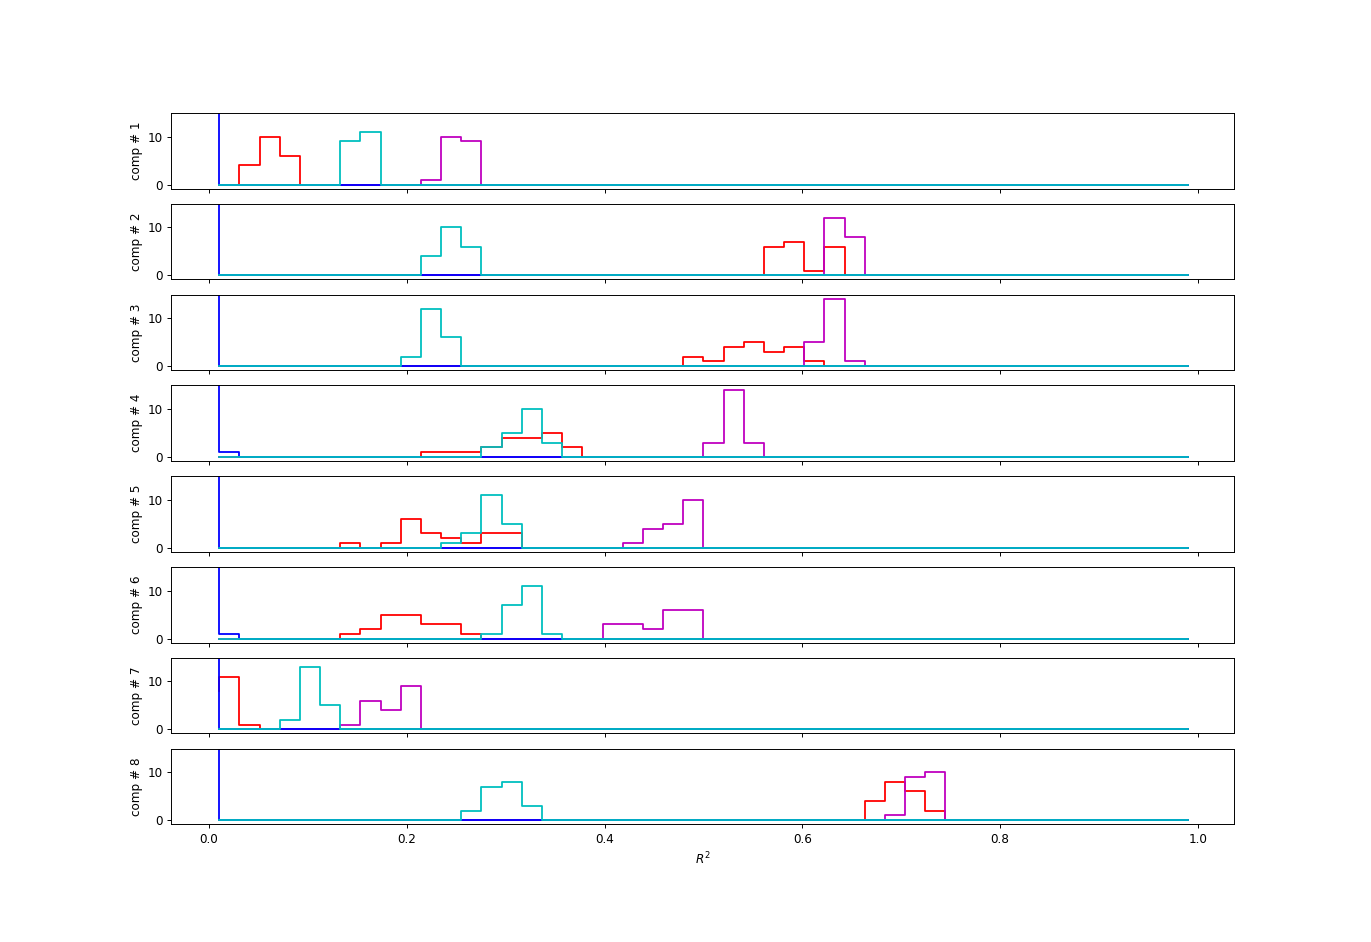

In [354]:
alf = 0
l1R = 0

n_bins = 50

%matplotlib notebook
fig, axs = plt.subplots(num_factors, sharex=True, sharey=True)
comps_toUse = np.arange(num_factors)
for i_comp, comp in enumerate(comps_toUse):

    for i_shuf,vals in enumerate(np.arange(n_rolls)):
#         data = R_test[comp,:,i_shuf,alf,l1R]**2
        data = R_test[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'r')
        else:
            axs[i_comp].step(edges_centers , counts , 'b')
        
#         data = R_train[comp,:,i_shuf,alf,l1R]**2
        data = R_train[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2
        
        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'm')
        else:
            axs[i_comp].step(edges_centers , counts , 'c')
        
        plt.xlabel('$R^2$')
        axs[i_comp].set_ylabel(f'comp # {comp+1}')
#         axs.subplot(sharey = ax1)
#         plt.legend(('test','train','test shuffle','train shuffle'))


<IPython.core.display.Javascript object>


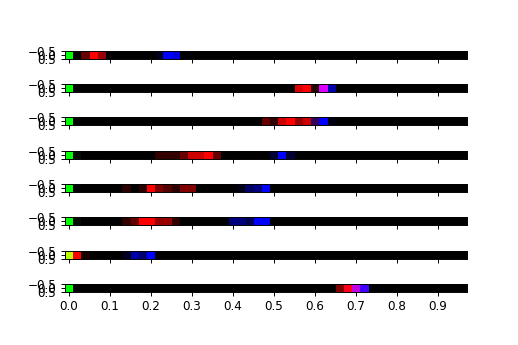

In [353]:
n_alphas = R_test.shape[3]
n_fac = R_test.shape[0]

fig, axs = plt.subplots(n_fac, sharex=True, sharey=False)

for i_fac in range(n_fac):

    im = np.zeros((n_alphas, len(edges_centers),3))
    for alf in range(n_alphas):
        data = R_test[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,0] = counts

        data = R_test[i_fac,:,1,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,1] = counts
        
        data = R_train[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,2] = counts

    im_norm = np.zeros((n_alphas, len(edges_centers),3))
    im_norm[:,:,0] = im[:,:,0] / np.max(im[:,:,0])
    im_norm[:,:,1] = im[:,:,1] / np.max(im[:,:,1])
    im_norm[:,:,2] = im[:,:,2] / np.max(im[:,:,2])
    axs[i_fac].imshow(im_norm)
    
    ticks_toUse = np.arange(0,len(edges_centers) , 5)
    axs[i_fac].set_xticks(ticks_toUse)
    axs[i_fac].set_xticklabels(np.round(edges_centers[ticks_toUse],1))

<IPython.core.display.Javascript object>


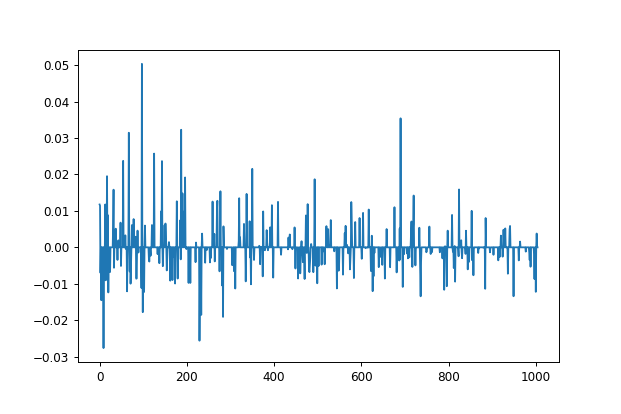

286


In [346]:
%matplotlib notebook

factors_toShow = np.array([1]) # 1-indexed
plt.figure()
for ii in factors_toShow:
    
    weights = theta_FF[1:,ii-1,0,0,0,0]
    if ii==2:
        weights=weights*-1
    print(np.sum(weights!=0))

    plt.plot(weights)
#     plt.plot(scipy.signal.savgol_filter(weights , 101 , 3));

In [356]:
y_reconstructed_FF.shape

(108000, 8, 20, 2, 1, 1)

<IPython.core.display.Javascript object>


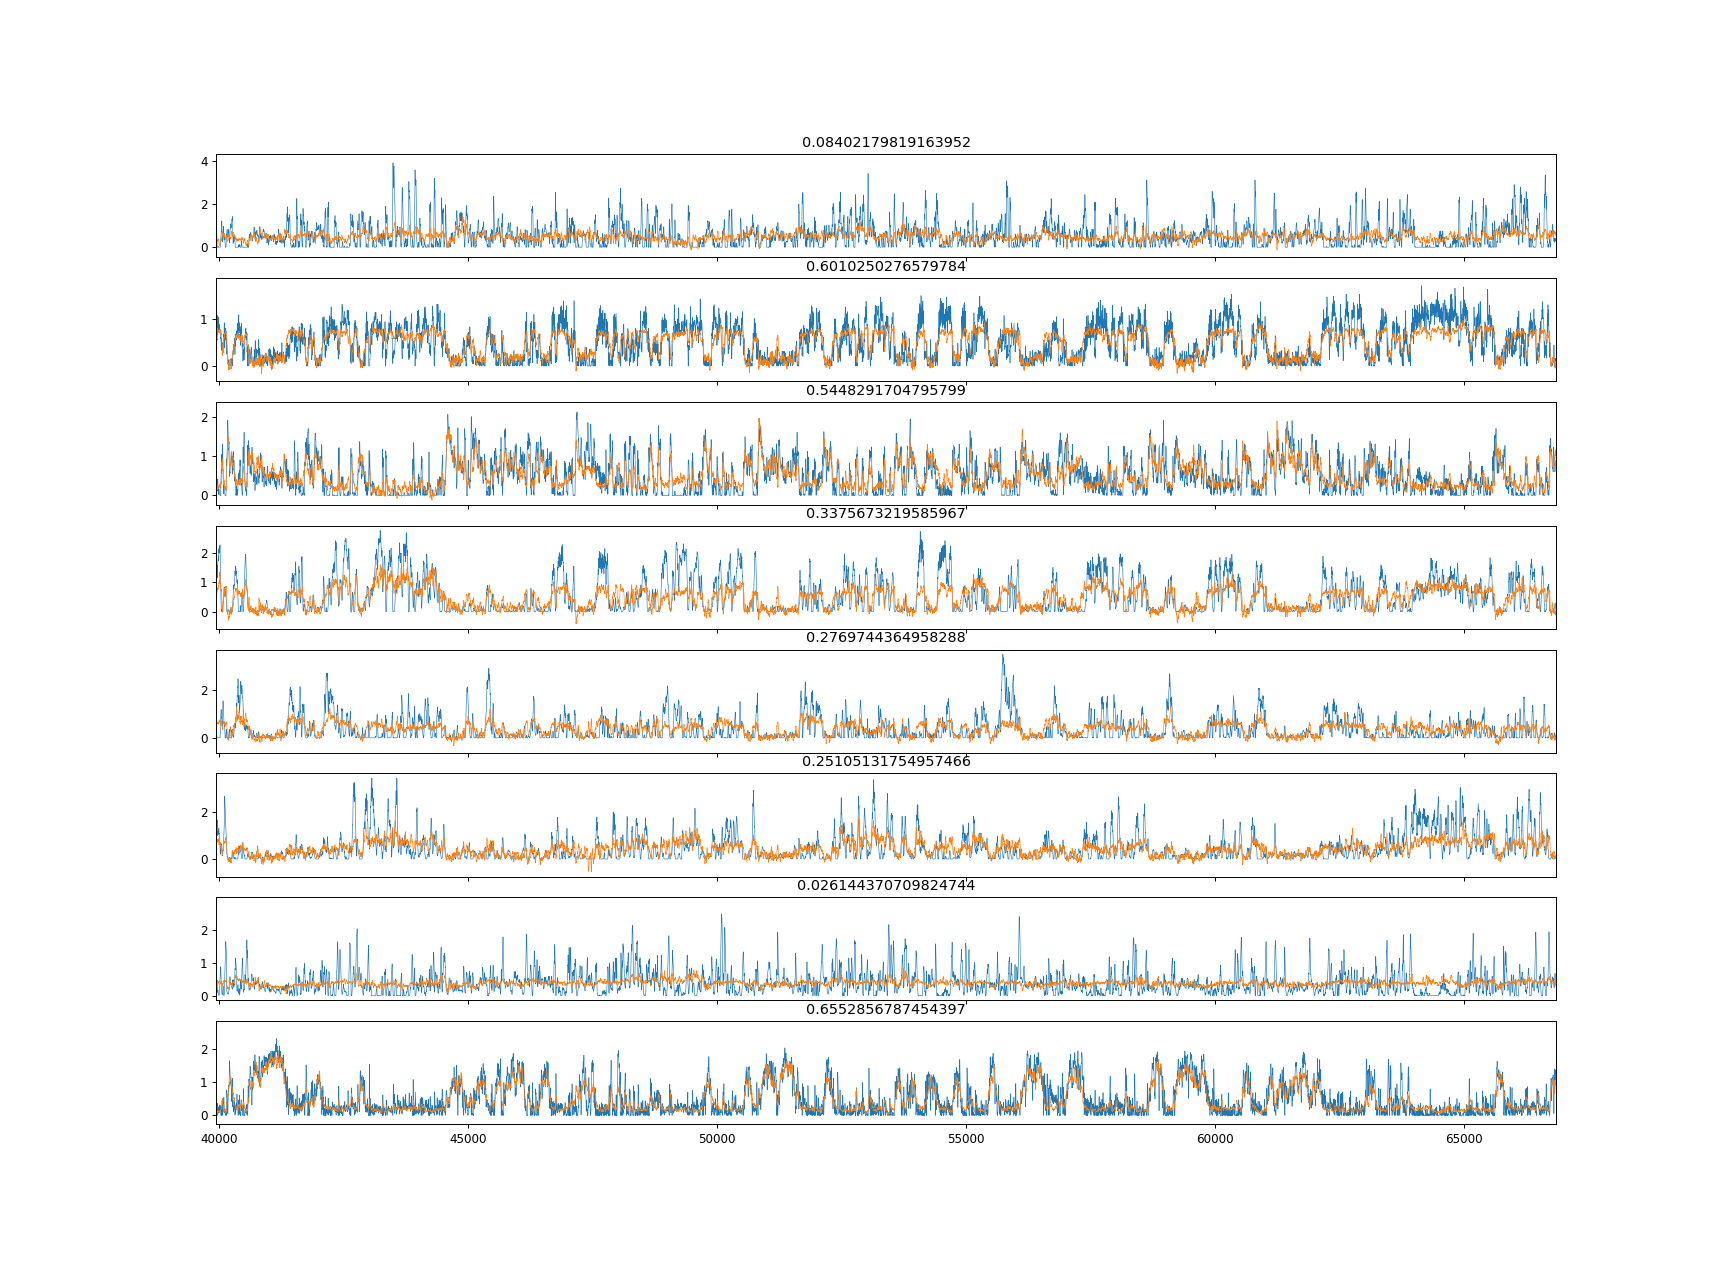

<IPython.core.display.Javascript object>


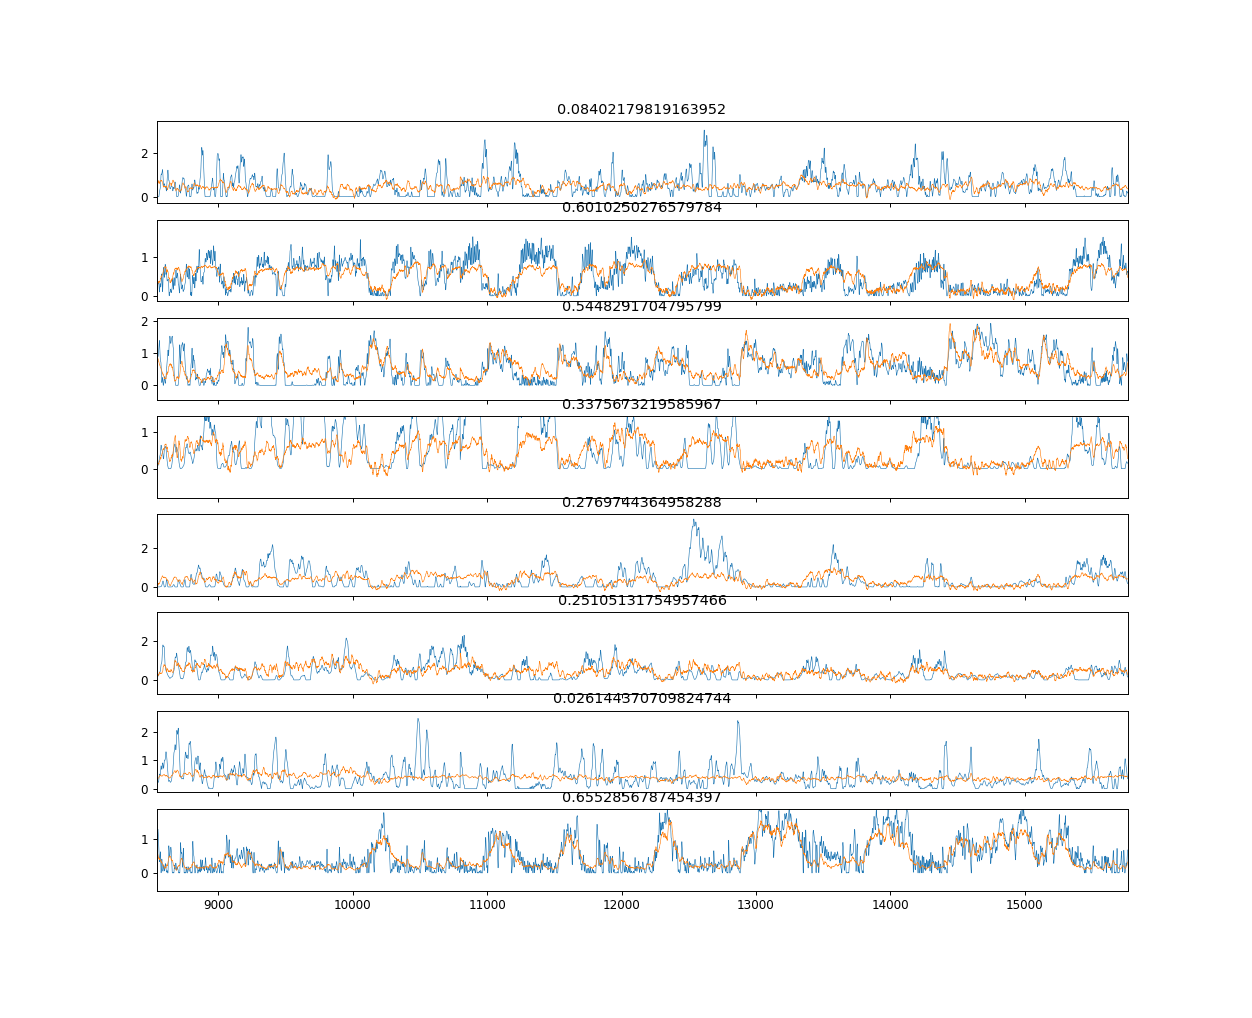

In [399]:
# full time series
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
    axs[iter_factor].plot(y_input[:,iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[:,iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)
    
# held out test data
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
    cv_idx_tmp = cv_idx[0]
    axs[iter_factor].plot(y_input[cv_idx_tmp[1],iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[cv_idx_tmp[1],iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)

In [ ]:
# compare NMF(neural data) to FR(behavioral data)_temporal factors



In [176]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input /= np.std(X_input, axis=0)
# X_input = scipy.stats.zscore(X_input , axis=0)

y_input = temporalFactors_s2pInd[:,:]

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = copy.deepcopy(y_input)

<IPython.core.display.Javascript object>


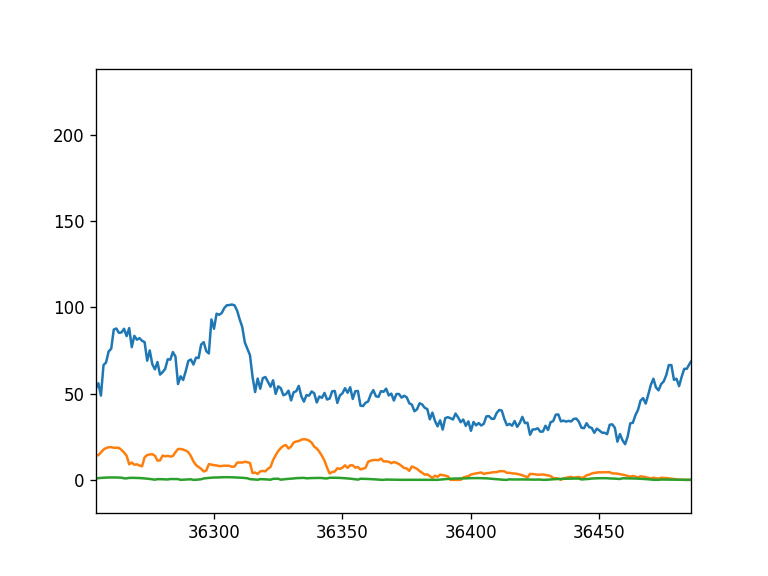

In [177]:
plt.figure()
plt.plot(X_input[:,np.array([0,1,1000])])

In [69]:
fac_temp.shape

(108000, 6)

In [191]:
fac_neuron2 = copy.deepcopy(fac_neuron)
fac_temp2 = copy.deepcopy(fac_temp)
rec_err2 = copy.deepcopy(rec_err)

In [198]:
import tensorly as tl

In [192]:
from tqdm.notebook import trange, tqdm
n_repeats = 1
ranks = np.array([15,16,17,18,19,20,21,22])

n_ranks = len(ranks)
n_neurons = X_input.shape[1]
n_timepoints = X_input.shape[0]

fac_neuron = list(np.zeros(n_ranks))
fac_temp = list(np.zeros(n_ranks))
rec_err = list(np.zeros(n_ranks))
for i_rank, rank in enumerate(tqdm(ranks)):
    fac_neuron[i_rank] = np.zeros((n_neurons , rank , n_repeats))
    fac_temp[i_rank] = np.zeros((n_timepoints , rank , n_repeats))
    rec_err[i_rank] = np.zeros((n_repeats))
    for i_rep in range(n_repeats):
        model = sklearn.decomposition.NMF(n_components=rank,
                                          init='random',
                                          solver='cd',
                                          beta_loss='frobenius',
                                          tol=0.000001,
                                          max_iter=10000,
                                          random_state=None,
                                          alpha=0.0,
                                          l1_ratio=0.0,
                                          verbose=False,
                                          shuffle=False,
                                          regularization='both'
                                         )

        fac_neuron[i_rank][:,:, i_rep] = model.fit_transform(X_input.T)
        fac_temp[i_rank][:,:, i_rep] = model.components_.T
        rec_err[i_rank][i_rep] = model.reconstruction_err_

  0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


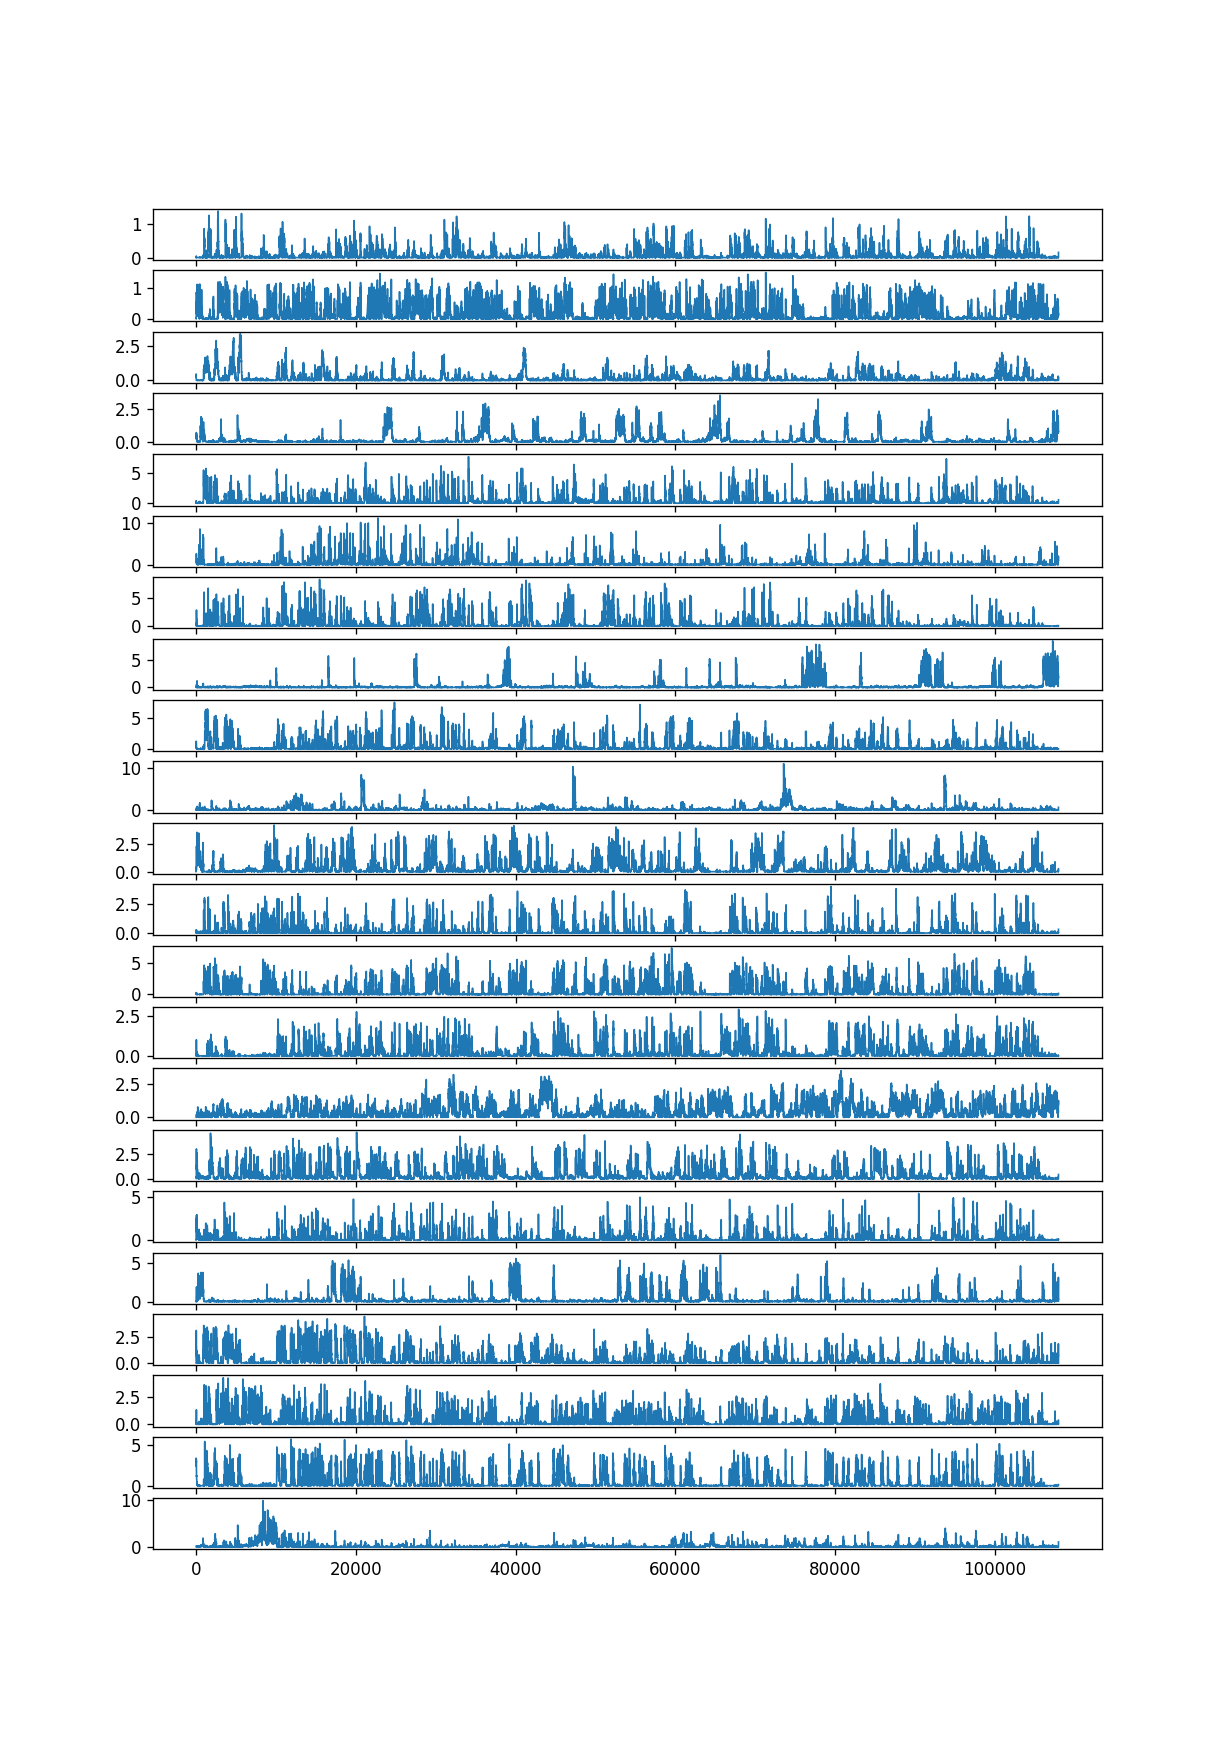

<IPython.core.display.Javascript object>


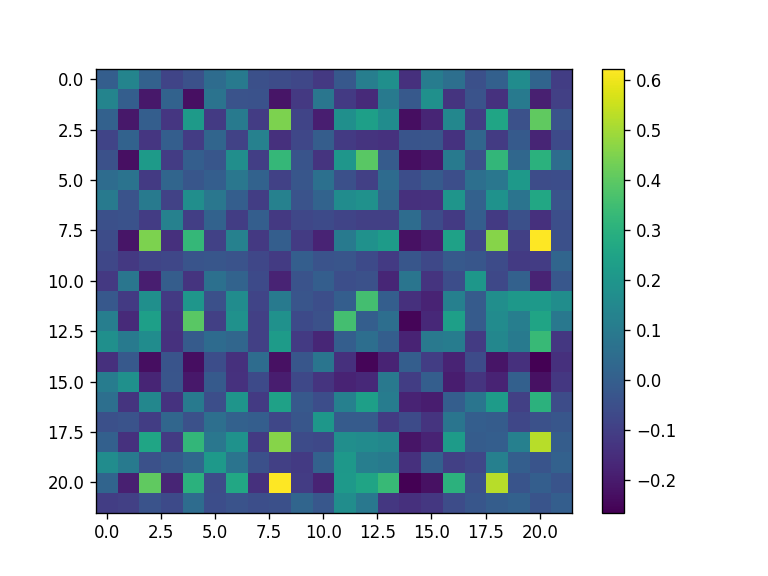

In [197]:
repeat_toPlot = 0 # 0-indexed
rank_toPlot = 22 # 

rank_idx_toPlot = np.where(ranks==rank_toPlot)[0][0]
n_components = rank_toPlot
fig, axs = plt.subplots(n_components , sharex=True , sharey=False)
for ii in range(n_components):
    axs[ii].plot(fac_temp[rank_idx_toPlot][:,ii,repeat_toPlot] , linewidth=1)

plt.figure()
plt.imshow(np.corrcoef(fac_temp[rank_idx_toPlot][:,:,repeat_toPlot].T) - np.eye(n_components),aspect='auto')
plt.colorbar()

In [184]:
def similarity_2(mat1 , mat2):
    '''
    This function compares the representations of two sets of vectors (columns of mat1 and columns of mat2).
    We assume that the vectors in mat1 and mat2 are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors
    
    Args:
        mat1 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat2
        mat2 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat1
    
    Returns:
        corr_avg (double): the average correlation coefficients between matched vectors
    '''
    corr = mat1.T @ mat2
    ind1 , ind2 = scipy.optimize.linear_sum_assignment(corr, maximize=True)
    corr_matched = np.zeros(len(ind1))
    for ii in range(len(ind1)):
        corr_matched[ii] = np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1]
    corr_avg = np.mean(corr_matched)
    return corr_avg , corr_matched , ind1 , ind2

def self_similarity_pairwise(mat_set):
    '''
    This function compares sets of matrices using the similarity_2 function.
    We assume that the vectors within the matrices are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors within each matrix
    
    Args:
        mat_set (np.ndarray): a 3D array where the columns are vectors we wish to match with the columns of 
    
    Returns:
        same as similarity_2, but over each combo
        combos: combinations of pairwise comparisons
    '''
    
    import itertools

    n_repeats = mat_set.shape[2]
    n_components = mat_set.shape[1]

    combos = np.array(list(itertools.combinations(np.arange(n_repeats),2)))
    n_combos = len(combos)

    corr_avg = np.zeros((n_combos))
    corr_matched = np.zeros((n_components , n_combos))
    ind1 = np.zeros((n_components , n_combos))
    ind2 = np.zeros((n_components , n_combos))
    for i_combo , combo in enumerate(combos):
        corr_avg[i_combo] , corr_matched[:,i_combo] , ind1[:,i_combo] , ind2[:,i_combo]  =  similarity_2(mat_set[:,:,combo[0]]  ,  mat_set[:,:,combo[1]])
    # print(corr_avg)
    return corr_avg, corr_matched, ind1, ind2, combos

In [185]:
n_ranks = len(ranks)

corr_avg = list(np.zeros(n_ranks))
corr_matched = list(np.zeros(n_ranks))
ind1 = list(np.zeros(n_ranks))
ind2 = list(np.zeros(n_ranks))
combos = list(np.zeros(n_ranks))

for i_rank, rank in enumerate(tqdm(ranks)):
    corr_avg[i_rank],
    corr_matched[i_rank],
    ind1[i_rank],
    ind2[i_rank],
    combos[i_rank] = self_similarity_pairwise(fac_temp[i_rank])
    
rec_err_mean = np.zeros(n_ranks)
rec_err_std = np.zeros(n_ranks)
for i_rank, rank in enumerate(ranks):
    rec_err_mean[i_rank] = np.mean(rec_err[i_rank])
    rec_err_std[i_rank] = np.std(rec_err[i_rank])


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


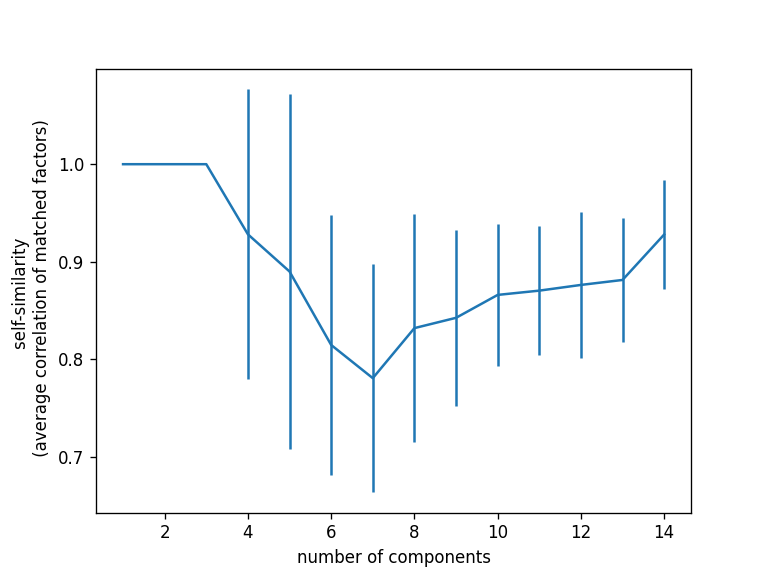

<IPython.core.display.Javascript object>


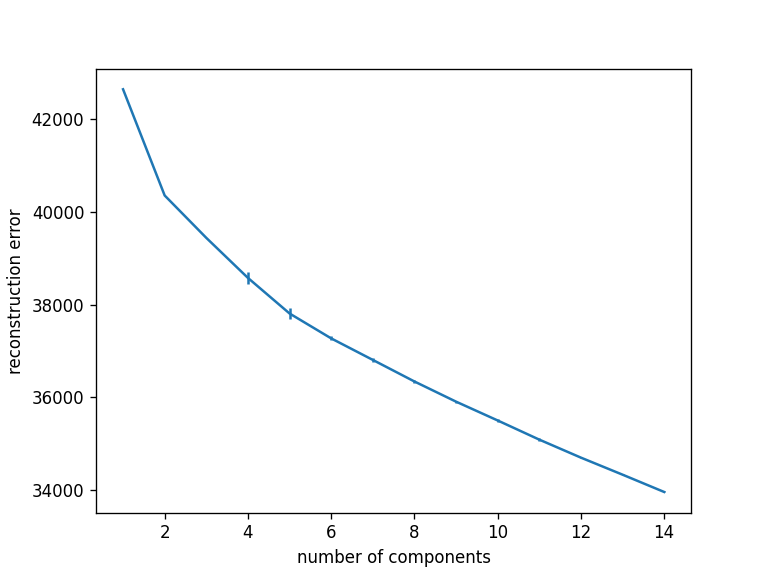

Text(0, 0.5, 'reconstruction error')

In [186]:
plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1, np.mean(corr_avg, axis=1), yerr=np.std(corr_avg, axis=1))
plt.xlabel('number of components')
plt.ylabel('self-similarity \n (average correlation of matched factors)')

plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1, rec_err_mean, yerr=rec_err_std)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [288]:
def make_xcorrMat(vector_set1 , vector_set2):
    return (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2)

In [ ]:
# figure out which factors to use

In [202]:
ranks = np.arange(14)+1

In [304]:
ranks = np.array([15,16,17,18,19,20,21,22])

In [313]:
len(fac_temp2)
fac_rank_toUse = 15 # actual value of rank
fac_repeat_toUse = 1 # 1-indexed repeat number

fac_rank_idx_toUse = np.where(ranks==fac_rank_toUse)[0][0]
fac_repeat_idx_toUse = fac_repeat_toUse-1

print(f' using model with rank = {fac_rank_toUse}, corresponding to rank index: {fac_rank_idx_toUse}, \n using repeat number: {fac_repeat_toUse}')\

fac_temp_toUse = fac_temp[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]
fac_neuron_toUse = fac_neuron[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]

 using model with rank = 15, corresponding to rank index: 0, 
 using repeat number: 1


In [358]:
X_input.shape

(108000, 1005)

Text(0.5, 0, 'aligned factor pair #')

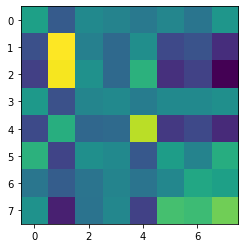

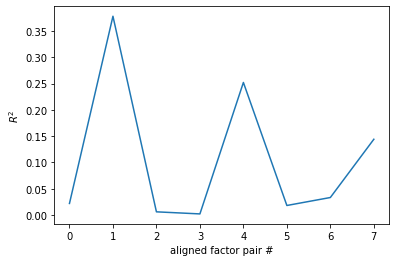

In [398]:
from scipy.stats import zscore
%matplotlib inline
### correlate neural factors with behavioral factors

## first align the two sets of factors

# start with a cross-covariance matrix

# vector_set1 = copy.deepcopy(fac_temp_toUse)
vector_set1 = copy.deepcopy(zscore(fac_temp_toUse,axis=0))
vector_set2 = copy.deepcopy(zscore(temporalFactors_s2pInd,axis=0))

xcorr_mat = make_xcorrMat(vector_set1 , vector_set2)
# plt.figure()
# plt.imshow(xcorr_mat)

xcorr_avg , xcorr_matched , xind1 , xind2  =  similarity_2(vector_set1  ,  vector_set2)

xcorr_mat_aligned = make_xcorrMat(vector_set1[:,xind1] , vector_set2[:,xind2])
R2_aligned_diag = np.diag(xcorr_mat_aligned)**2
plt.figure()
plt.imshow(xcorr_mat_aligned)
plt.colorbar

plt.figure()
plt.plot(R2_aligned_diag)
plt.ylabel('$R^2$')
plt.xlabel('aligned factor pair #')

In [391]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

cca = CCA(n_components=vector_set2.shape[1])
X_cc, Y_cc = cca.fit_transform(vector_set1, vector_set2)

In [392]:
pca = PCA(n_components=vector_set2.shape[1])
X_pc = pca.fit_transform(vector_set1)
X_pc_scree = pca.explained_variance_ratio_
Y_pc = pca.fit_transform(vector_set2)
Y_pc_scree = pca.explained_variance_ratio_

In [393]:
xcorr_mat_aligned = make_xcorrMat(X_cc , Y_cc)
R2_aligned_diag = np.diag(xcorr_mat_aligned)**2

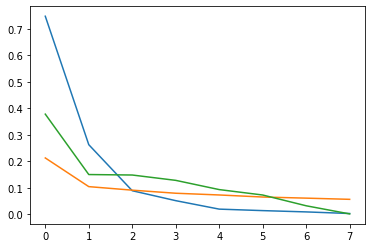

In [394]:
plt.figure()
plt.plot(R2_aligned_diag)
plt.plot(X_pc_scree)
plt.plot(Y_pc_scree)

<IPython.core.display.Javascript object>


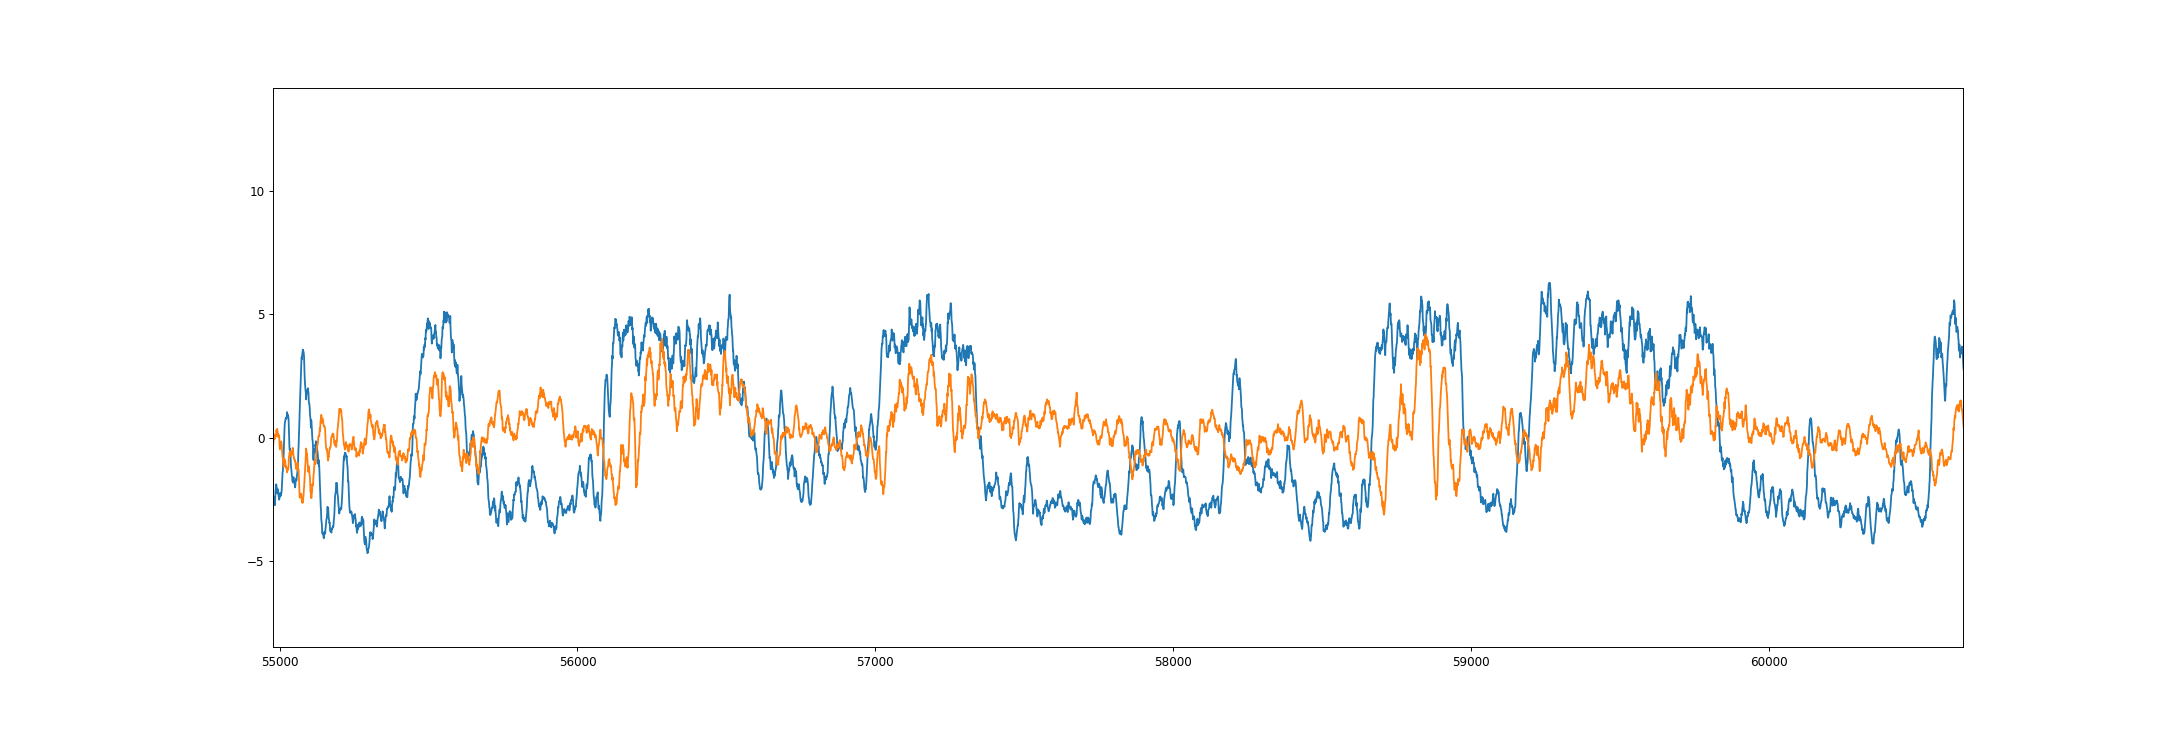

In [379]:
%matplotlib notebook
plt.figure()
plt.plot(X_c[:,:2])
# plt.plot(Y_c[:,0])
# plt.plot(-X_pc[:,1]/30)
# plt.plot(-Y_pc[:,0])


In [350]:
cca.score(vector_set1, vector_set2)
# cca.transform(vector_set1).shape

-1.09438868520902

treadmill, train R: 0.8822762507831636
treadmill, test  R: 0.8772212840377442
R^2: 0.7695171811688287


<IPython.core.display.Javascript object>


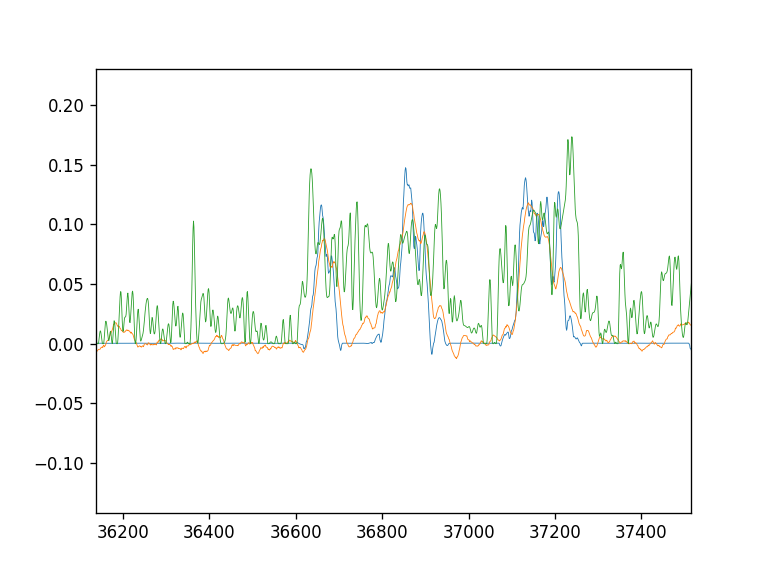

In [61]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,7]/10 , linewidth = 0.5)

treadmill, train R: 0.8471622646934773
treadmill, test  R: 0.8401484750669375


<IPython.core.display.Javascript object>


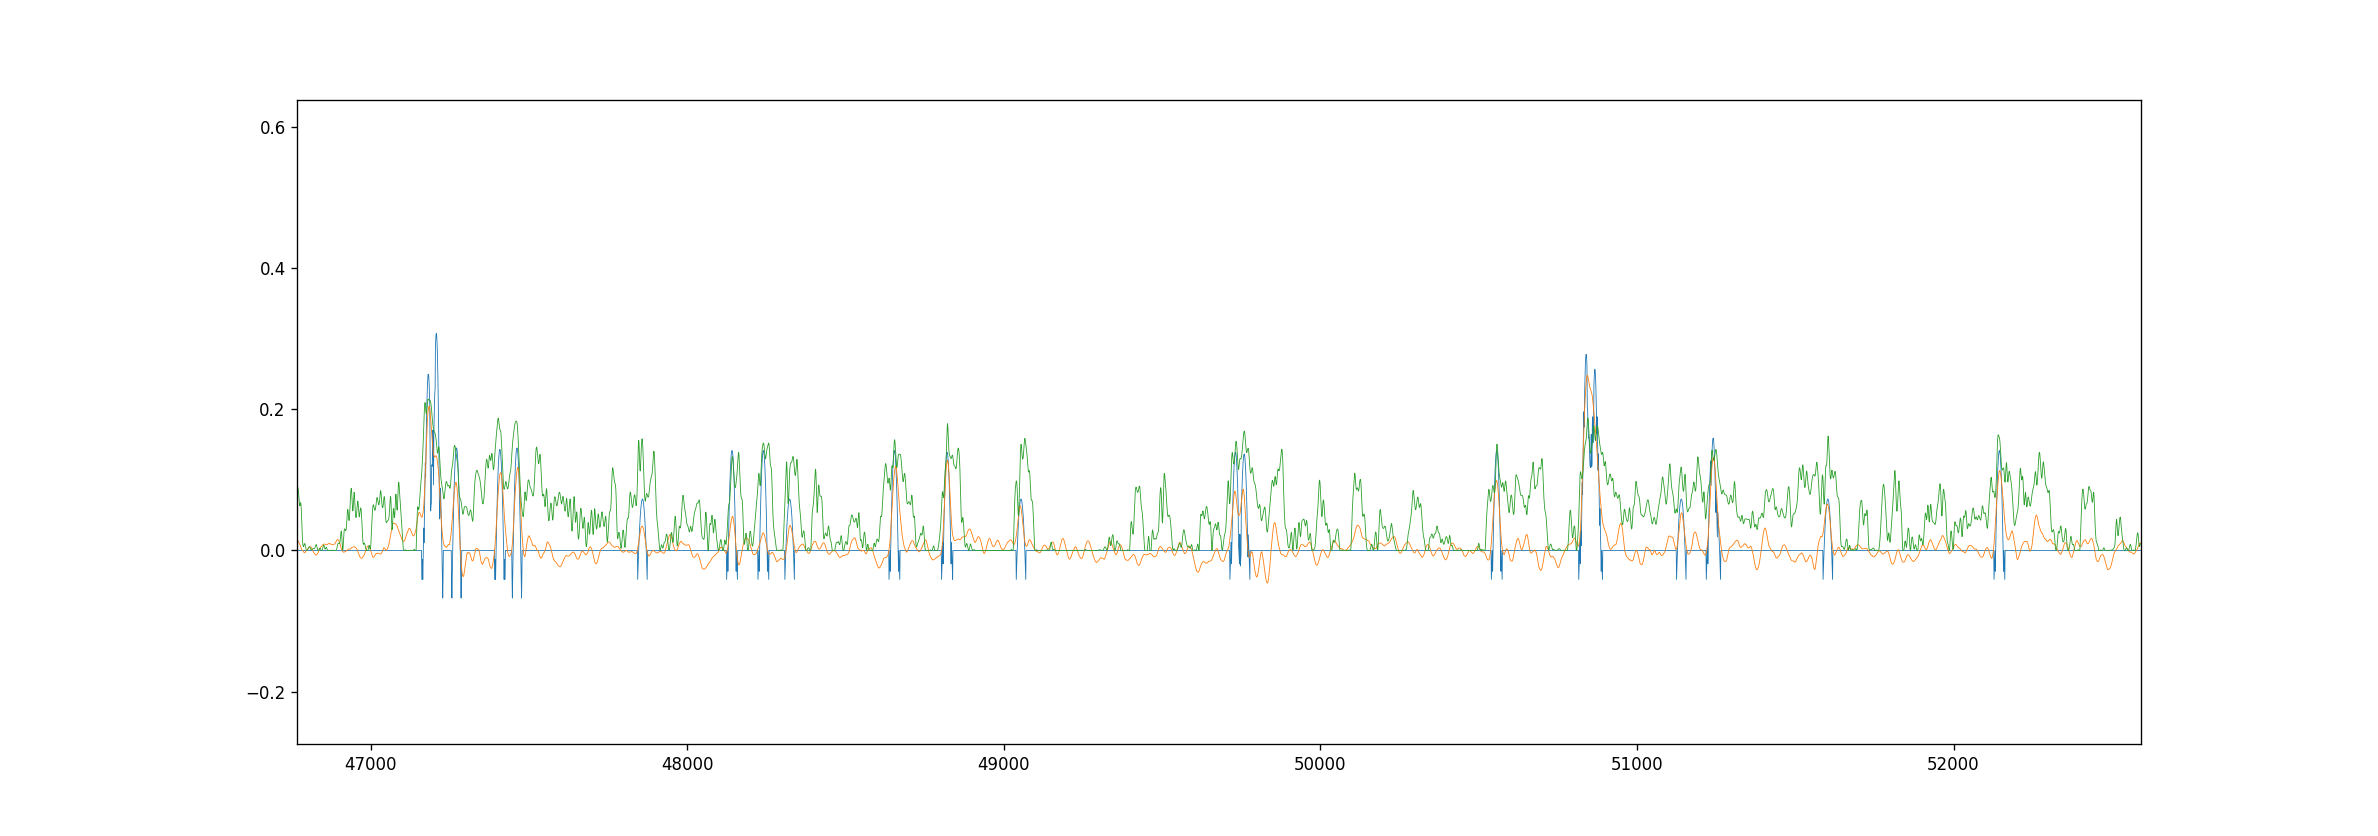

In [37]:
## Correlate to licking signal
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = spks[IsCell_ROIClassifier==True,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,2]/10 , linewidth = 0.5)

In [39]:
theta_FF.shape
F_zscore_roll[:,IsCell_ROIClassifier==True].shape

(108000, 1005)

In [40]:
np.sum(IsCell_ROIClassifier)

1005

In [62]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 8

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


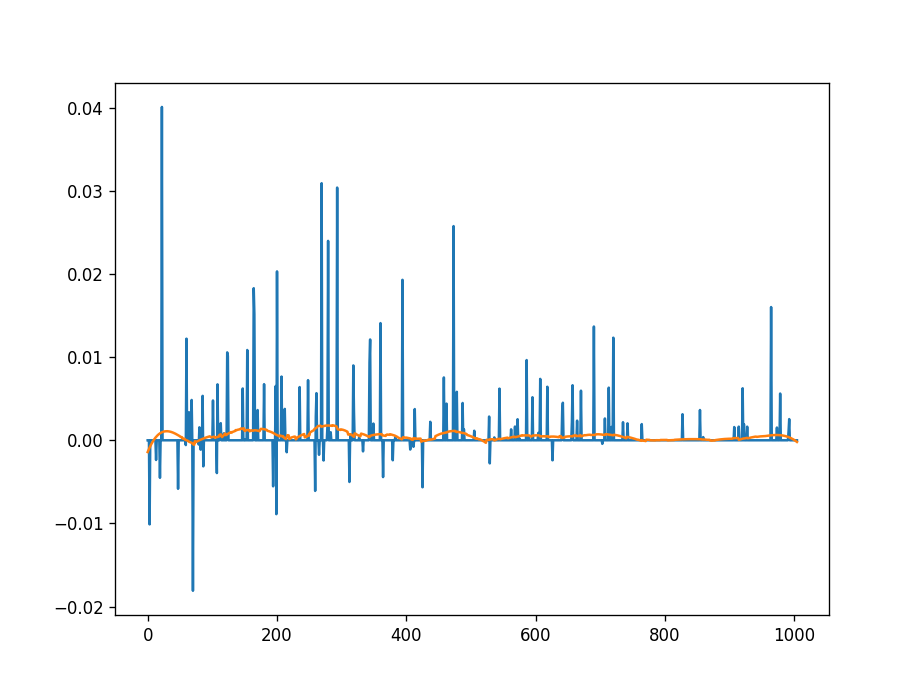

In [63]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3));